In [3]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import time
import h5py

 
import tensorflow as tf
from keras_preprocessing.image import ImageDataGenerator
from keras.models import Model, load_model
from keras.layers import Dense,MaxPool2D,Dropout,Flatten,Conv2D,GlobalAveragePooling2D,Activation
from keras.optimizers import Adam
from keras.utils import to_categorical
 
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
 
from random import choice,shuffle
from scipy import stats as st

from collections import deque

In [4]:
def gather_data(num_samples):
     
    global rock, paper, scissor, nothing
     
    # Initialize the camera
    cap = cv2.VideoCapture(1)
 
    # trigger tells us when to start recording
    trigger = False
     
    # Counter keeps count of the number of samples collected
    counter = 0
     
    # This the ROI size, the size of images saved will be box_size -10
    box_size = 234
     
    # Getting the width of the frame from the camera properties
    width = int(cap.get(3))
 
 
    while True:
         
        # Read frame by frame
        ret, frame = cap.read()
         
        # Flip the frame laterally
        frame = cv2.flip(frame, 1)
         
        # Break the loop if there is trouble reading the frame.
        if not ret:
            break
             
        # If counter is equal to the number samples then reset triger and the counter
        if counter == num_samples:
            trigger = not trigger
            counter = 0
         
        # Define ROI for capturing samples
        cv2.rectangle(frame, (width - box_size, 0), (width, box_size), (0, 250, 150), 2)
         
        # Make a resizable window.
        cv2.namedWindow("Image Collection", cv2.WINDOW_NORMAL)
         
         
        # If trigger is True than start capturing the samples
        if trigger:
             
            # Grab only slected roi
            roi = frame[5: box_size-5 , width-box_size + 5: width -5]
             
            # Append the roi and class name to the list with the selected class_name
            eval(class_name).append([roi, class_name])
                                     
            # Increment the counter 
            counter += 1
         
            # Text for the counter
            text = "Collected Samples of {}: {}".format(class_name, counter)
             
        else:
            text = "Press 'r' to collect rock samples, 'p' for paper, 's' for scissor and 'n' for nothing"
         
        # Show the counter on the imaege
        cv2.putText(frame, text, (3, 350), cv2.FONT_HERSHEY_SIMPLEX, 0.45, (0, 0, 255), 1, cv2.LINE_AA)
         
        # Display the window
        cv2.imshow("Collecting images", frame)
         
        # Wait 1 ms
        k = cv2.waitKey(1)
         
        # If user press 'r' than set the path for rock directoryq
        if k == ord('r'):
             
            # Trigger the variable inorder to capture the samples
            trigger = not trigger
            class_name = 'rock'
            rock = []
            
             
        # If user press 'p' then class_name is set to paper and trigger set to True  
        if k == ord('p'):
            trigger = not trigger
            class_name = 'paper'
            paper = []
         
        # If user press 's' then class_name is set to scissor and trigger set to True  
        if k == ord('s'):
            trigger = not trigger
            class_name = 'scissor'
            scissor = []
                     
        # If user press 's' then class_name is set to nothing and trigger set to True
        if k == ord('n'):
            trigger = not trigger
            class_name = 'nothing'
            nothing = []
         
        # Exit if user presses 'q'
        if k == ord('q'):
            break
             
    #  Release the camera and destroy the window
    cap.release()
    cv2.destroyAllWindows()

In [5]:
no_of_samples = 100
gather_data(no_of_samples)

KeyboardInterrupt: 

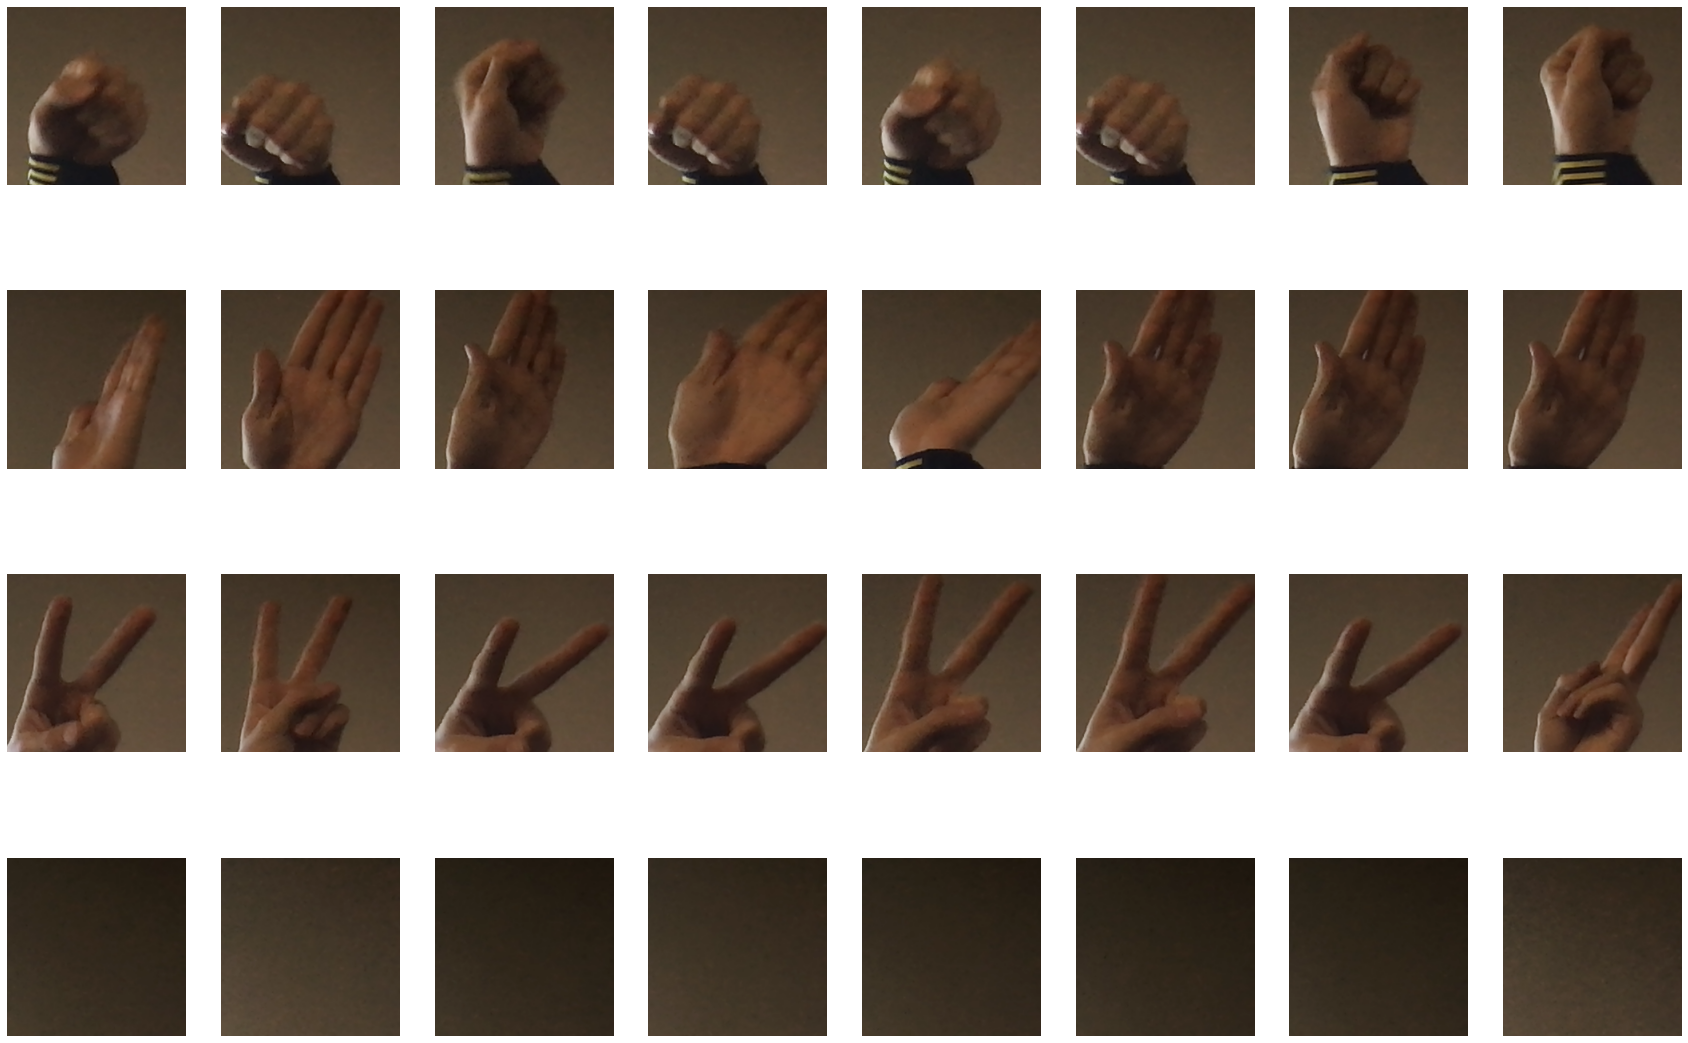

In [ ]:
# Set the figure size
plt.figure(figsize=[30,20])
 
# Set the rows and columns
rows, cols = 4, 8
 
# Iterate for each class
for class_index, each_list in enumerate([rock, paper, scissor,nothing]):
     
    # Get 8 random indexes, since we will be showing 8 examples of each class.
    r = np.random.randint(no_of_samples, size=8);
     
    # Plot the examples
    for i, example_index in enumerate(r,1):
        plt.subplot(rows,cols,class_index*cols + i );plt.imshow(each_list[example_index][0][:,:,::-1]);plt.axis('off');

In [ ]:
# Combine the labels of all classes together
labels = [tupl[1] for tupl in rock] + [tupl[1] for tupl in paper] + [tupl[1] for tupl in scissor] +[tupl[1] for tupl in nothing]
 
# Combine the images of all classes together
images = [tupl[0] for tupl in rock] + [tupl[0] for tupl in paper] + [tupl[0] for tupl in scissor] +[tupl[0] for tupl in nothing]
 
# Normalize the images by dividing by 255, now our images are in range 0-1. This will help in training.
images = np.array(images, dtype="float") / 255.0
 
# Print out the total number of labels and images.
print('Total images: {} , Total Labels: {}'.format(len(labels), len(images)))
 
# Create an encoder Object
encoder = LabelEncoder()
 
# Convert Lablels to integers. i.e. nothing = 0, paper = 1, rock = 2, scissor = 3 (mapping is done in alphabatical order)
Int_labels = encoder.fit_transform(labels)
 
# Now the convert the integer labels into one hot format. i.e. 0 = [1,0,0,0]  etc.
one_hot_labels = to_categorical(Int_labels, 4)
 
# Now we're splitting the data, 75% for training and 25% for testing.
(trainX, testX, trainY, testY) = train_test_split(images, one_hot_labels, test_size=0.25, random_state=50)
 
# Empty memory from RAM
images = []
 
 
# This can further free up memory from RAM but be careful, if you won't be able to change split % after this.
# rock, paper, scissor = [], [], []

Total images: 400 , Total Labels: 400


In [ ]:
# This is the input size which our model accepts.
image_size = 224
 
# Loading pre-trained NASNETMobile Model without the head by doing include_top = False
N_mobile = (tf.keras.applications.NASNetMobile)( input_shape=(image_size, image_size, 3), include_top=False, weights='imagenet')
 
# Freeze the whole model 
N_mobile.trainable = False
     
# Adding our own custom head
# Start by taking the output feature maps from NASNETMobile
x = N_mobile.output
 
# Convert to a single-dimensional vector by Global Average Pooling. 
# We could also use Flatten()(x) GAP is more effective reduces params and controls overfitting.
x = GlobalAveragePooling2D()(x)
 
# Adding a dense layer with 712 units
x = Dense(712, activation='relu')(x) 
 
# Dropout 40% of the activations, helps reduces overfitting
x = Dropout(0.40)(x)
 
# The fianl layer will contain 4 output units (no of units = no of classes) with softmax function.
preds = Dense(4,activation='softmax')(x) 
 
# Construct the full model
model = Model(inputs=N_mobile.input, outputs=preds)
 
# Check the number of layers in the final Model
print ("Number of Layers in Model: {}".format(len(model.layers[:])))

Number of Layers in Model: 773


In [ ]:
# Adding transformations that I know would help, you can feel free to add more.
# I'm doing horizontal_flip = False, in case you aren't sure which hand you would be using you can make that True.
 
augment = ImageDataGenerator( 
     
        rotation_range=30,
        zoom_range=0.25,
        width_shift_range=0.10,
        height_shift_range=0.10,
        shear_range=0.10,
        horizontal_flip=False,
        fill_mode="nearest"
)


In [ ]:
	
model.compile(optimizer=Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# Set batchsize according to your system
epochs = 15
batchsize = 20
 
# Start training
history = model.fit(x=augment.flow(trainX, trainY, batch_size=batchsize), validation_data=(testX, testY), 
steps_per_epoch= len(trainX) // batchsize, epochs=epochs)
 
# Use model.fit_generator function instead if TF version < 2.2
#history = model.fit_generator(x = augment.flow(trainX, trainY, batch_size=batchsize), validation_data=(testX, testY), 
#steps_per_epoch= len(trainX) // batchsize, epochs=epochs)

Epoch 1/15
15/15 [==============================] - 24s 924ms/step - loss: 1.0688 - accuracy: 0.5467 - val_loss: 0.6282 - val_accuracy: 0.8500
Epoch 2/15
15/15 [==============================] - 10s 699ms/step - loss: 0.5322 - accuracy: 0.8133 - val_loss: 0.3053 - val_accuracy: 0.9700
Epoch 3/15
15/15 [==============================] - 11s 744ms/step - loss: 0.3156 - accuracy: 0.9200 - val_loss: 0.2156 - val_accuracy: 0.9500
Epoch 4/15
15/15 [==============================] - 10s 687ms/step - loss: 0.2739 - accuracy: 0.9200 - val_loss: 0.1539 - val_accuracy: 0.9900
Epoch 5/15
15/15 [==============================] - 21s 1s/step - loss: 0.2189 - accuracy: 0.9333 - val_loss: 0.1125 - val_accuracy: 0.9900
Epoch 6/15
15/15 [==============================] - 10s 682ms/step - loss: 0.1961 - accuracy: 0.9467 - val_loss: 0.1049 - val_accuracy: 0.9800
Epoch 7/15
15/15 [==============================] - 13s 898ms/step - loss: 0.1695 - accuracy: 0.9533 - val_loss: 0.0814 - val_accuracy: 0.9900
Ep

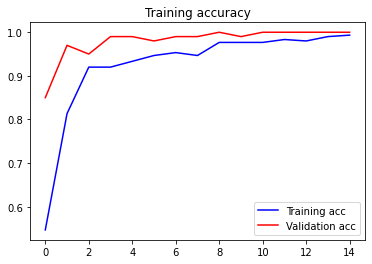

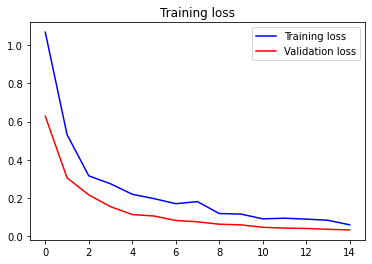

In [ ]:
# Plot the accuracy and loss curves
 
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
 
epochs = range(len(acc))
 
plt.plot(epochs, acc, 'b', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training accuracy')
plt.legend()
 
plt.figure()
 
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training loss')
plt.legend()
 
plt.show()


In [ ]:
	
model.save("rps4.h5")

In [1]:
	
from keras.models import Model, load_model
model = load_model("rps4.h5")

In [2]:
# This list will be used to map probabilities to class names, Label names are in alphabetical order.
label_names = ['nothing', 'paper', 'rock', 'scissor']
label_numbers = [0,1,2,3]

import serial
import time
import cv2
import numpy as np

port = "/dev/tty.usbmodem14401"

cap = cv2.VideoCapture(1)
box_size = 234
width = int(cap.get(3))
 
while True:
     
    ret, frame = cap.read()
    if not ret:
        break
         
    frame = cv2.flip(frame, 1)
            
    cv2.rectangle(frame, (width - box_size, 0), (width, box_size), (0, 250, 150), 2)
         
    cv2.namedWindow("Rock Paper Scissors", cv2.WINDOW_NORMAL)
 
    roi = frame[5: box_size-5 , width-box_size + 5: width -5]
     
    # Normalize the image like we did in the preprocessing step, also convert float64 array.
    roi = np.array([roi]).astype('float64') / 255.0
  
    # Get model's prediction.
    pred = model.predict(roi)
     
    # Get the index of the target class.
    target_index = np.argmax(pred[0])
 
    # Get the probability of the target class
    prob = np.max(pred[0])

    # Show results
    cv2.putText(frame, "prediction: {} {:.2f}%".format(label_names[np.argmax(pred[0])], prob*100 ),
                (10, 40), cv2.FONT_HERSHEY_SIMPLEX, 0.90, (0, 0, 255), 2, cv2.LINE_AA)
    
    cv2.imshow("Rock Paper Scissors", frame)

    arduino = serial.Serial('/dev/tty.usbmodem14301', 9600, timeout=.1)
    time.sleep(0.9)
    arduino.write((label_numbers[np.argmax(pred[0])]))
    print((label_numbers[np.argmax(pred[0])]))
    
    k = cv2.waitKey(1)
    if k == ord('q'):
        break
            
 
cap.release()
cv2.destroyAllWindows()

1/1 [==============================] - 3s 3s/step
0
1/1 [==============================] - 0s 54ms/step
0
1/1 [==============================] - 0s 53ms/step
0
1/1 [==============================] - 0s 60ms/step
0
1/1 [==============================] - 0s 52ms/step
0
1/1 [==============================] - 0s 51ms/step
2
1/1 [==============================] - 0s 49ms/step
2
1/1 [==============================] - 0s 55ms/step
2
1/1 [==============================] - 0s 53ms/step
2
1/1 [==============================] - 0s 52ms/step
2
1/1 [==============================] - 0s 54ms/step
0
1/1 [==============================] - 0s 57ms/step
0
1/1 [==============================] - 0s 51ms/step
0
1/1 [==============================] - 0s 53ms/step
0
1/1 [==============================] - 0s 53ms/step
0
1/1 [==============================] - 0s 59ms/step
0
1/1 [==============================] - 0s 54ms/step
0
1/1 [==============================] - 0s 57ms/step
0
1/1 [=========================